# Fit Spectre XPS

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from xpsplot import XPSData
%matplotlib inline
from scipy.optimize import curve_fit
import pandas as pd

# TODO
# * chercher la relation entre la largeur à mi-hauteur d'une gaussienne 
#   et d'une lorentzienne
#   GLS/GLP => http://www.casaxps.com/help_manual/line_shapes.htm

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.5)

## Fit Functions

### General functions

Gaussian functions

\begin{equation}
    gauss(x, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2} \right)
\end{equation}

Lorentz function

\begin{equation}
    lorentz(x, x_o, \gamma) = \frac{\gamma \big/ 2\pi}{\left(\gamma \big/ 2\right)^2 + (x - x_o)^2}
\end{equation}

Primitive functions are a gaussian/lorentzian mixing.

In [74]:
def gauss(x, mu=0., sigma=1.):
    """ gaussian funcion of mean mu and standard deviation sigma """
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
def lorentz(x, xo=0., gamma=1.):
    """ lorentz distribution of with gamma and position xo """
    return gamma / (2 * np.pi) * 1 / ((gamma / 2)**2 + (x - xo)**2)

def mix_g_l(x, xo, fwhm, mixing):
    """ 
    primitive function for the fit. The function is define as :
    
    sum_g_l(x) = mixing * gauss(x) + (1 - mixing) lorentz(x)
    
    WARNING: fwhm for gaussian and lorentz function are note equal
    """
    return mixing * gauss(x, xo, fwhm) + (1 - mixing) * lorentz(x, xo, 1.3*fwhm)

### Functions define from casaXPS

GLS and GLP => http://www.casaxps.com/help_manual/line_shapes.htm

#### GLP, Gaussian Lorentzian product as define in casaXPS

$\alpha$ is the mixing factor.

\begin{equation}
    GLP(x, x_o, \text{fwhm}, \alpha) =
    \exp\left(-\frac{4\ln 2 \; (1 - \alpha) (x - x_o)^2}{\text{fwhm}^2}\right)
    \frac{1}{\displaystyle
        1 + 4 \alpha (x - x_o)^2 \big/ \text{fwhm}^2
    }
\end{equation}

#### GLS, Gaussian Lorentzian sum as define in casaXPS

$\alpha$ is the mixing factor.

\begin{equation}
    GLS(x, x_o, \text{fwhm}, \alpha) =
    (1-\alpha)\,\exp\left(-\frac{4\ln 2 \; (x - x_o)^2}{\text{fwhm}^2}\right)
    +
    \alpha
    \frac{1}{\displaystyle
        1 + 4 (x - x_o)^2 \big/ \text{fwhm}^2 
    }
\end{equation}

In [75]:
def GLP(x, xo, fwhm=1, mixing=.5):
    """ 
    gaussian/lorentzian Product form 
    
    Args:
        x: scalar or array 
        xo (float): position
        fwhm (float): full width at half maximum
        mixing (float): proportion of lorentzian function
    """
    return np.exp(- 4 * np.log(2) * (1 - mixing) * (x - xo)**2 / fwhm**2) / (1 + 4 * mixing * (x - xo)**2 / fwhm**2)
    
def GLS(x, xo, fwhm=1, mixing=.5):
    """
    gaussian/lorentzian sum form 
    
    Args:
        x: scalar or array 
        xo (float): position
        fwhm (float): full width at half maximum
        mixing (float): proportion of lorentzian function
    """
    return (1 - mixing) * np.exp(-4 * np.log(2) * (x - xo)**2 / fwhm**2) + mixing / (1 + 4 * (x - xo)**2 / fwhm**2)

GLS is slightly larger  at the bottom

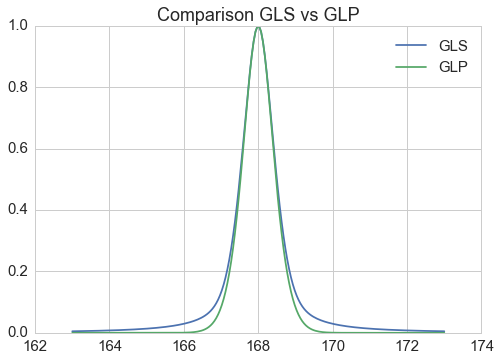

In [76]:
x = np.linspace(163, 173, 200)
plt.plot(x, GLS(x, 168), label="GLS")
plt.plot(x, GLP(x, 168), label="GLP")
plt.title("Comparison GLS vs GLP")
plt.legend()

## Curve fit

* use `curve_fit` form `scipy.optimize`

### Check on toy datas

Make toy data with GLP function plus a random distribution.

In [77]:
x = np.linspace(-2, 2, 100)
xo =0
fwhm = 1
mixing = .5
y = GLP(x, xo, fwhm, mixing)
ye = np.array([yi + 0.1 * np.random.uniform(-yi, yi) for yi in y])
print("xo   = %f\nfwhm = %f\nmix  = %f" % (xo, fwhm, mixing))

xo   = 0.000000
fwhm = 1.000000
mix  = 0.500000


Fit GLP on randomized GLP data.

xo   = -0.004369
fwhm = 1.000789
mix  = 0.499957


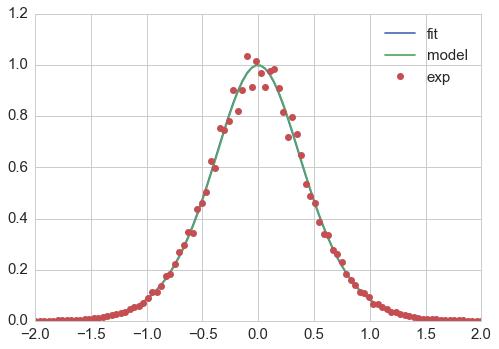

In [78]:
params, pcov = curve_fit(GLP, x, ye)
plt.plot(x, GLP(x, *params), label="fit")
plt.plot(x, y, label="model")
plt.plot(x, ye, "o", label="exp")
plt.legend()
print("xo   = %f\nfwhm = %f\nmix  = %f" % tuple(params))

### Load real datas

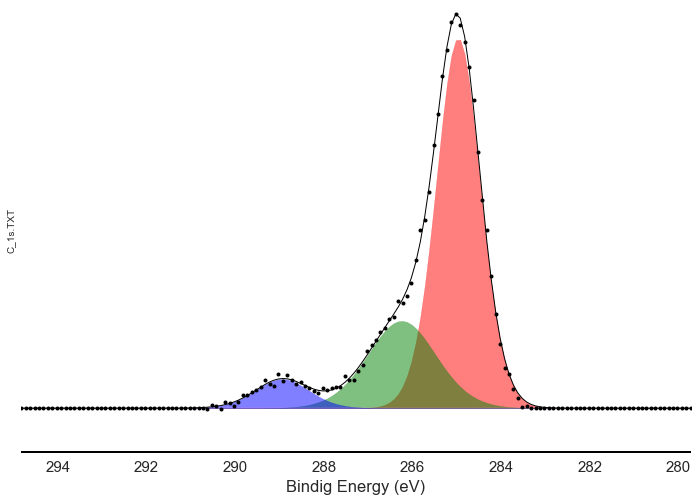

In [79]:
C1s_data = XPSData.from_file("C_1s.TXT")
C1s_data.substract_bg()
columns = C1s_data.list_columns(to_print=False)
columns.remove("KE")
S2p_data2.get_plot(
    fill=True,
    columns=columns,
    legend=False
)

In [80]:
df = C1s_data.data["Exp"]
df.index.name = "BE"
df.head()

BE
294.824    0.0
294.724    0.0
294.624    0.0
294.524    0.0
294.424    0.0
Name: Exp, dtype: float64

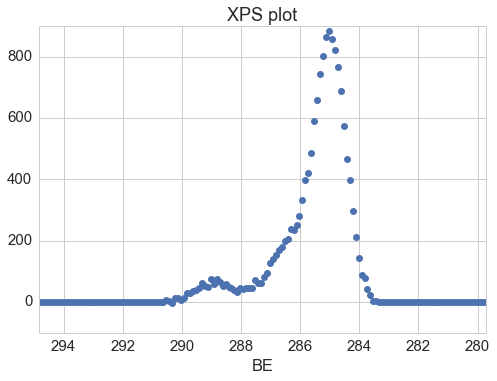

In [81]:
ax = df.plot(kind="line", marker="o", linewidth=0)
ax.set_title("XPS plot")

### Fit a sum of GLS or GLP functions

First define the function for the fit.

In [82]:
def function(x, *param, mixing=.5, basis=GLS):
    """ 
    sum of several primitive functions such as
    
    contaction = sum_i coefs_i * basis(params_i)
    
    args:
        x: float or numpy array of float
        coefs: list of floats
        params: list of parameters (xo, fwhm, mixing) of a primitive function
        basis: a basis function
    """
    nparam = len(param) - 1
    if nparam % 2 != 0:
        raise ValueError("param must be a list of (coef, position) ...")
    
    fwhm = param[-1]
    
    x = np.array(x)
    values = np.zeros(x.shape)
    for i in range(0, nparam, 2):
        values += param[i] * basis(x, param[i+1], fwhm=fwhm, mixing=mixing)
    
    return values

fit =  888 GLS(285.0) +  150 GLS(286.4) +   54 GLS(288.9) + 
fwhm =  1.17631544778


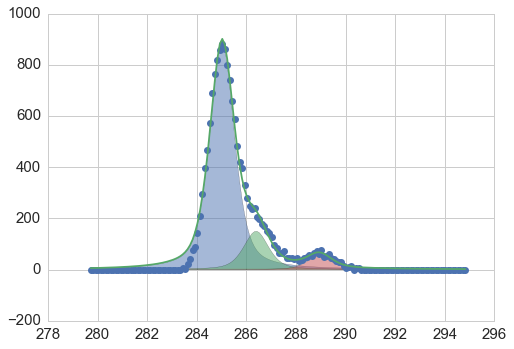

In [83]:
params, popt = curve_fit(
    function,
    xdata=df.index.values, 
    ydata=df.values,
    p0=(800, 285, 200, 287, 100, 289, 1),
    bounds=(3*[0, 280] + [.8], 3*[4000, 294] + [1.3])
)
plt.plot(df.index, df, "o")
plt.plot(df.index, function(df.index, *params))
line = ""
for i in range(0, len(params) - 2, 2):
    plt.fill(df.index, params[i] * GLS(df.index, params[i+1], fwhm=params[-1], mixing=.5), alpha=.5)
    line += "%4.f GLS(%4.1f) + " % (params[i], params[i+1])
    
print("fit = " + line.strip("+"))
print("fwhm = ", params[-1])
#print(pcov)

## Monte Carlo Fit

Fit with a monte carlo procedure.

In [86]:
# initial parameter guess
guess = [800, 285, 200, 287, 100, 289, 1]
amplitude = 3 * [30, .2] + [0.01]
nparams = len(guess)
# parameters boundaries
bounds=(2*[10, 280] + [10, 288] + [0.8], 2*[2000, 294] + [100, 290] + [1.1])
# freeze some parameters
freeze = len(guess) * [False]

temperature = 0.5

# data to fit
x = df.index.values
ye = df.values
npts = len(x)

# fit function
f = function

# initialize with first guess parameters
ym = f(x, *guess)
Q_old = np.linalg.norm(ye - ym) / npts
pmin = guess.copy()
pold = guess.copy()
pnew = guess.copy()
Q_min = Q_old

# save paramters
save = True
freq_save = 100
params = []

# Main loop
nstep = 100000
accept = 0
i = 0
while accept < nstep:
    i += 1
    
    # randomly change one parameter
    choice = False
    while not choice:
        # select a parameter
        k = np.random.randint(nparams)
        if not freeze[k]:
            step = amplitude[k] * np.random.uniform(-1, 1)
            attemp = pold[k] + step
            # check bounds of parameter k
            while not (bounds[0][k] < attemp < bounds[1][k]):
                step /= 2
                attemp = pold[k] + step
            choice = True
            pnew[k] = attemp
            #print(pold[k], pnew[k], step, amplitude[k], bounds[0][k], bounds[1][k])
    
    # compute probability
    ym = f(x, *pnew)
    Q_new = np.linalg.norm(ye - ym) / npts
    
    # accept or not step
    newstep = False
    if Q_new < Q_old: # accept without condition
        pold = pnew.copy()
        Q_old = Q_new
        
        if Q_new < Q_min:
            Q_min = Q_new
            pmin = pnew.copy()
            #print("%3d %3d %6.2f%% %10.4f"% (i, accept, accept / i * 100, Q_new))

        accept += 1

    else: # accept with a give probability
        proba = np.exp(-(Q_new - Q_old) / temperature)

        if proba > np.random.rand(): 
            # accept
            pold = pnew.copy()
            Q_old = Q_new
            accept += 1
    
    if save and i % freq_save == 0:
        params.append(pold + [Q_old])
            
    if i % (nstep / 10) == 0 and accept != 0:
        print("%6d %6d %6.2f%% %10.4f"% (i, accept, accept / i * 100, Q_min))


 10000   6300  63.00%     3.1778
 20000  12819  64.09%     2.6889
 30000  20131  67.10%     2.6889
 40000  27513  68.78%     2.6889
 50000  36129  72.26%     2.6889
 60000  43364  72.27%     2.6889
 70000  50512  72.16%     2.6889
 80000  57099  71.37%     1.9397
 90000  63419  70.47%     1.9397
100000  70330  70.33%     1.9397
110000  77519  70.47%     1.9397
120000  84239  70.20%     1.9397
130000  90927  69.94%     1.9397
140000  98471  70.34%     1.9397


fit =  151 GLS(286.2) +  958 GLS(285.0) +   63 GLS(288.8) + 
fwhm =  1.0959965505850808


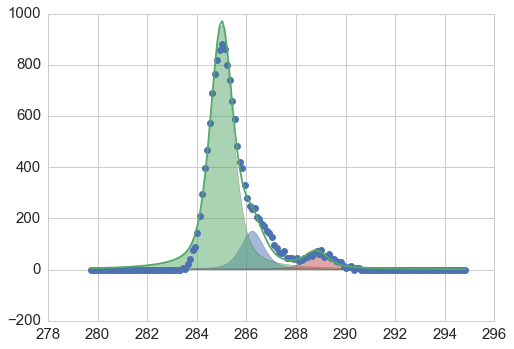

In [87]:
plt.plot(df.index, df, "o")
plt.plot(df.index, function(df.index, *pmin))
line = ""
for i in range(0, nparams - 2, 2):
    plt.fill(df.index, pmin[i] * GLS(df.index, pmin[i+1], fwhm=pmin[-1], mixing=.5), alpha=.5)
    line += "%4.f GLS(%4.1f) + " % (pmin[i], pmin[i+1])
    
print("fit = " + line.strip("+"))
print("fwhm = ", pmin[-1])

In [88]:
params = np.array(params)
params.shape

(1419, 8)

In [89]:
df_params = pd.DataFrame({"p%d" % i: params[:,i] for i in range(8)}, index=range(len(params)))
df_params.head()

,p0,p1,p2,p3,p4,p5,p6,p7
0,758.892502,285.004441,196.437698,286.754820,28.882585,289.222742,0.995414,5.041230
1,727.718199,285.136411,337.026837,286.907862,12.942366,288.913757,1.020916,6.652617
2,820.041282,284.831035,369.522257,286.869386,87.129478,289.465147,1.013147,6.977471
3,857.955630,284.958569,411.911996,286.261620,99.292261,289.959691,1.029833,4.438293
4,862.586807,284.913871,488.620804,285.384238,63.947039,289.623748,0.971033,5.603589


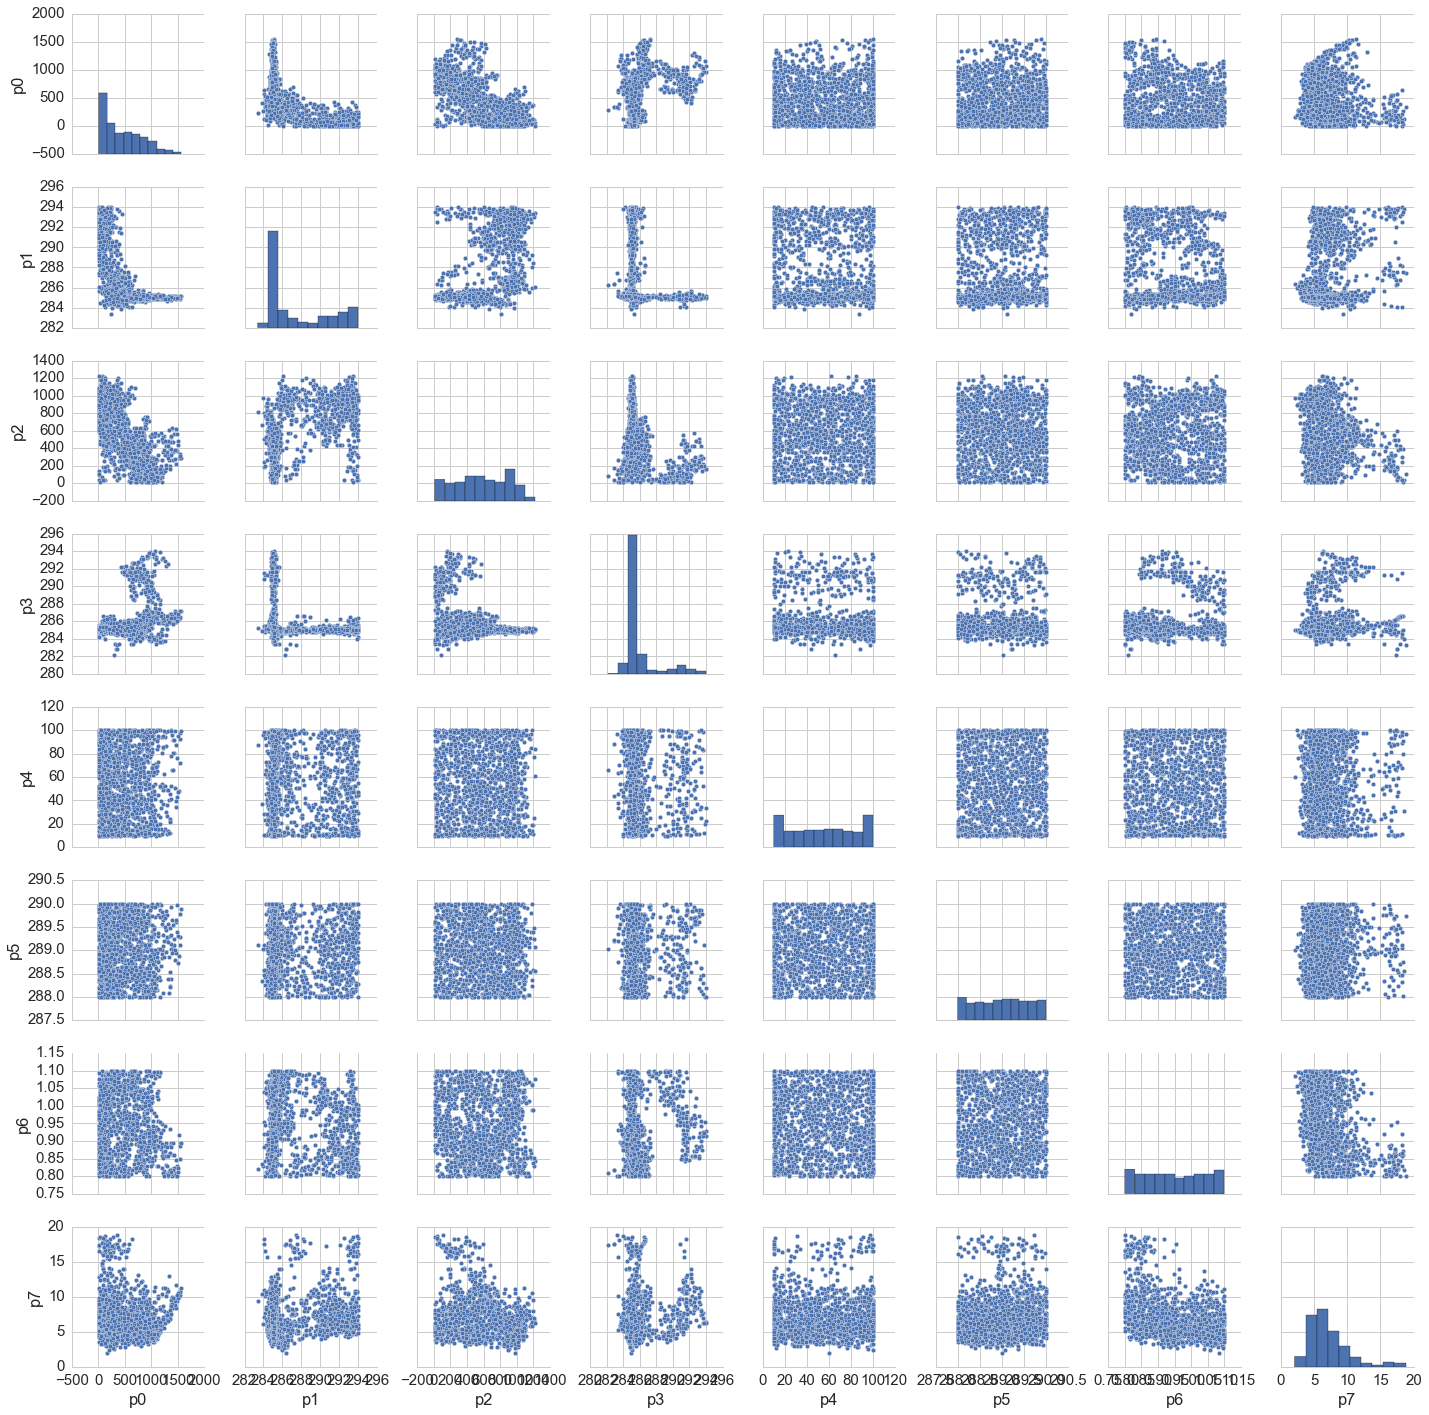

In [90]:
sns.pairplot(df_params)